In [265]:
EMBEDDINGS_DIRECTORY = './vstore' # directory of stored embeddings

In [ ]:
from langchain_ollama import ChatOllama
from langchain.vectorstores import FAISS
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, AIMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from typing import List, Annotated

# Embedding and Vector Store

In [279]:
embedding_model = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")

vectorstore = FAISS.load_local(
  EMBEDDINGS_DIRECTORY, 
  embeddings = embedding_model, 
  allow_dangerous_deserialization = True
  )
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# LLM

In [268]:
# llm = ChatOllama(model="llama3", temperature=0)
def choose_model(model_name: str):
    if model_name == "ollama":
        return ChatOllama(model="llama3", temperature=0)
    elif model_name == "openai":
        return ChatOpenAI(model="gpt-4", temperature=0)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")
llm = choose_model("ollama")
llm.invoke("what are you ")


AIMessage(content="I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm not a human, but rather a computer program designed to simulate conversation and answer questions to the best of my ability based on my training.\n\nI'm a type of artificial intelligence (AI) called a large language model (LLM), which means I've been trained on a massive dataset of text from various sources, including books, articles, and online conversations. This training enables me to understand and generate human-like language, allowing us to have a conversation that feels natural and engaging.\n\nI can answer questions, provide information, offer suggestions, and even engage in creative activities like storytelling or generating ideas. I'm constantly learning and improving my responses based on the interactions I have with users like you, so please bear with me if I make any mistakes – it's all part of my ongoing development!", addition

# Router

In [269]:
# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related 17000 objects in the Miami University's Richard and Carole Cocks Art Museum collection, including: paintings, sculptures, and photographs.

Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.

Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""


# LangGraph

In [270]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    route: str 
    documents: List[str] 
    question: str
    generation: str
    keywords: str

In [271]:
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""

# Nodes

In [272]:
def extract_keywords(state):
    print("--- Extracting Keywords ---")
    question = state["question"]

    # Strict and focused prompt
    prompt = (
        "You are an art museum curator using a vector search engine to retrieve artworks from a digital collection. "
        "Extract only the most relevant search keywords from the user's question.\n\n"
        "Your output MUST be:\n"
        "- A strict list of relevant keywords or short phrases\n"
        "- Comma-separated\n"
        "No explanations, no extra text, no labels\n"
        " Only keywords related to paintings, artists, styles, periods, materials, etc.\n\n"
        "Correct format:\n"
        "Input: What are some oil paintings by Van Gogh from his time in Arles?\n"
        "Output:  Van Gogh, oil painting, Arles\n\n"
        "Do NOT output like this:\n"
        "- 'Here are your keywords: ...'\n"
        "- 'The relevant terms are...'\n"
        "- Any bullet points or sentences\n\n"
        f"User question: \"{question}\"\n"
        "Keywords (comma-separated):"
    )

    # LLM call
    keywords = llm.invoke([HumanMessage(content=prompt)]).content.strip()

    print(f"Extracted Keywords from the question: {keywords}")
    return {"keywords": keywords}




def retrieve(state): # Retriver
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    keywords = state["keywords"]
    question = state["question"]

    documents_question = retriever.invoke(question)
    documents_keywords = retriever.invoke(keywords)

    # Deduplicate by page content
    seen_pages = set()
    unique_documents = []
    for doc in documents_question + documents_keywords:
        if doc.page_content not in seen_pages:
            unique_documents.append(doc)
            seen_pages.add(doc.page_content)

    print(f"Retrieved {len(unique_documents)} unique documents for question: {question} with keywords: {keywords}")
    return {"documents": unique_documents}


def generate(state):
    """

    Generate an AI response using the LLM, given the current state and retrieved documents.

    Args:
        state (dict): The current graph state, expected to contain 'messages' and 'documents'.

    Returns:
        dict: Updated state with the AI response appended to the 'messages' key.
    """
    print("-----GENERATE------")

    question = state["question"]
    documents = state["documents"]
    
    context = "\n".join([doc.page_content for doc in documents])  # adjust if needed
    prompt = rag_prompt.format(context=context, question=question)
    generation = llm.invoke([HumanMessage(content=prompt)])
    return {"generation": generation}

In [273]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

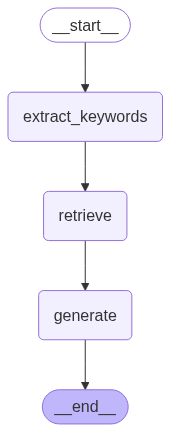

In [274]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
builder = StateGraph(State)

# Nodes 
builder.add_node("retrieve", retrieve)
builder.add_node("generate", generate)
builder.add_node("extract_keywords",extract_keywords)

# Edges
builder.add_edge(START, "extract_keywords")
builder.add_edge("extract_keywords","retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [281]:
question = {"question":"Find me some paintings by Van Gogh in the Miami University Art Museum collection."}
response = graph.invoke(question)
print(response["generation"].content)

--- Extracting Keywords ---
Extracted Keywords from the question: Van Gogh, Miami University Art Museum
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 51.54inputs/s]

Retrieved 6 unique documents for question: Find me some paintings by Van Gogh in the Miami University Art Museum collection. with keywords: Van Gogh, Miami University Art Museum
-----GENERATE------


Based on the provided context, I found that George Deem created a painting titled "Van Gogh's Bedroom at Arles" in 1979, which is part of the Miami University Art Museum collection. This painting is categorized under Modern & Contemporary-Paintings-20th C. & Later. Unfortunately, there are no original paintings by Van Gogh himself in the collection, as Deem's work is a reproduction or interpretation of Van Gogh's famous piece.


In [276]:
question = {"question":"tell me more about 'The Long Voyage Home'"}
response = graph.invoke(question)
print(response["generation"].content)

--- Extracting Keywords ---
Extracted Keywords from the question: Ives, The Long Voyage Home, painting
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 118.23inputs/s]

Retrieved 7 unique documents for question: tell me more about 'The Long Voyage Home' with keywords: Ives, The Long Voyage Home, painting
-----GENERATE------


Based on the provided context, here's the answer:

"The Long Voyage Home" is a mixed-media painting created by Varujan Boghosian in 1996. The artwork features a wooden sailboat at night with a paper sail, wood mast, painted background, and a circular wooden moon with glitter.


In [280]:
question = {"question":"tell me more about 'Pima jar'"}
response = graph.invoke(question)
print(response["generation"].content)

--- Extracting Keywords ---
Extracted Keywords from the question: Pima, jar
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 71.50inputs/s]

Retrieved 3 unique documents for question: tell me more about 'Pima jar' with keywords: Pima, jar
-----GENERATE------


The "Pima jar" is a Native American basket created by the Pima people in the early 20th century. The exact medium used to create the jar is unknown, but it is made from willow and cottonwood materials. It is part of the Edna M. Kelly Collection and is classified under African, Oceanic & New World Cultures-North America.
